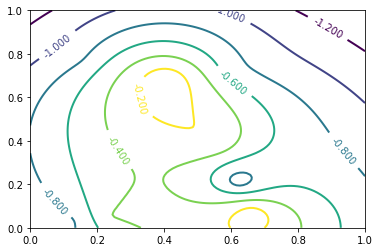

In [1]:
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1981)

x, y, z = np.random.random((3, 10))
xi, yi = np.mgrid[0:1:100j, 0:1:100j]
func = Rbf(x, y, z, function='linear')
zi = -1*func(xi, yi)

fig, ax = plt.subplots()

# Plot flowlines
dy, dx = np.gradient(-zi.T)

# Contour gridded head observations
contours = ax.contour(xi, yi, zi[:,::-1], linewidths=2)
ax.clabel(contours)


plt.show()

In [2]:
def get_idx(np_linarray, val):
    i = 0
    if (val < np_linarray[0]) or (val > np_linarray[-1]):
        i = -1
    else:
        for i in range(len(np_linarray)-1):
            if val < np_linarray[i+1] and val > np_linarray[i]:
                break
        
    return i

def get_grad(X, Y, z, pos):
    dy, dx = np.gradient(-z.T)
    grad = [np.nan, np.nan]
    
    idx_x = get_idx(X[:,0], pos[0])
    idx_y = get_idx(Y[0,:], pos[1])    
    grad = np.array([ dx[idx_y,idx_x] , dy[idx_y,idx_x] ])
    #print(idx_x, idx_y, pos[0], pos[1], grad, zi[idx_x, idx_y])
    return grad


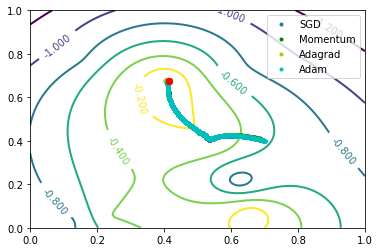

In [3]:
position_init = np.array([0.7, 0.6]) # other init position?
velocity = np.array([-0.01, -0.01])
alpha = 0.5
learning_rate = 0.05                 # high or low learning rate?
eproch = 10000                       # less eproch?
delta = 1e-7
rho1 = 0.9
rho2 = 0.999

def func_sgd(theta, eproch, xi, yi, zi, learning_rate):
    l_posx = []
    l_posy = []
    for i in range(eproch):
        grad = get_grad(xi, yi, zi, theta)
        theta = theta-grad*learning_rate
        l_posx.append(theta[0])
        l_posy.append(1-theta[1])
    
    return l_posx, l_posy

def func_momentum(theta, eproch, xi, yi, zi, learning_rate, alpha, velocity):
    l_posx = []
    l_posy = []
    for i in range(eproch):
        grad = get_grad(xi, yi, zi, theta)
        velocity = alpha*velocity - grad*learning_rate
        theta  = theta + velocity
        l_posx.append(theta[0])
        l_posy.append(1-theta[1])

    return l_posx, l_posy


def func_adagrad(theta, eproch, xi, yi, zi, learning_rate, delta):
    l_posx = []
    l_posy = []
    r = 0
    for i in range(eproch):
        grad = get_grad(xi, yi, zi, theta)
        r += np.dot(grad, grad)
        theta  = theta- learning_rate/(delta+np.sqrt(r)) * grad
        l_posx.append(theta[0])
        l_posy.append(1-theta[1])

    return l_posx, l_posy


def func_adam(theta, eproch, xi, yi, zi, learning_rate, delta, rho1, rho2):
    l_posx = []
    l_posy = []
    s = 0
    r = 0
    for i in range(eproch):
        grad = get_grad(xi, yi, zi, theta)
        t = i+1
        s = rho1 * s + (1-rho1) * grad
        r = rho2 * 2 + (1-rho2) * np.dot(grad, grad)
        s_hat = s / (1-rho1**t)
        r_hat = r / (1-rho2**t)
        
        theta  = theta- learning_rate/(delta+np.sqrt(r_hat)) * s_hat
        l_posx.append(theta[0])
        l_posy.append(1-theta[1])

    return l_posx, l_posy


l_posx_gd,l_posy_gd = func_sgd(
                        position_init, eproch, 
                        xi, yi, zi, learning_rate)

l_posx_momentum,l_posy_momentum = func_momentum(
                        position_init, eproch, 
                        xi, yi, zi, learning_rate, alpha, velocity)

l_posx_adagrad,l_posy_adagrad = func_adagrad(
                        position_init, eproch, 
                        xi, yi, zi, learning_rate, delta)

l_posx_adam,l_posy_adam = func_adam(
                        position_init, eproch, 
                        xi, yi, zi, learning_rate, delta, rho1, rho2)

fig, ax = plt.subplots()
contours = ax.contour(xi, yi, zi[:,::-1], linewidths=2)
ax.clabel(contours)
ax.plot(l_posx_gd, l_posy_gd, ".", label="SGD")
ax.plot(l_posx_momentum, l_posy_momentum, "g.", label="Momentum")
ax.plot(l_posx_adagrad, l_posy_adagrad, "y.", label="Adagrad")
ax.plot(l_posx_adam,    l_posy_adam,    "c.", label="Adam")

ax.plot(l_posx_gd[-1],       l_posy_gd[-1],       "ro")
ax.plot(l_posx_momentum[-1], l_posy_momentum[-1], "ro")
ax.plot(l_posx_adagrad[-1],  l_posy_adagrad[-1],  "ro")
ax.plot(l_posx_adam[-1],     l_posy_adam[-1],     "ro")
ax.legend()
plt.show()